In [2]:
import galsim
import batsim.transforms
import batsim.stamp
import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib.pyplot as plt
import fpfs

from tqdm import tqdm, trange
from scipy.optimize import curve_fit

In [3]:
cosmos = galsim.COSMOSCatalog()

bigfft = galsim.GSParams(maximum_fft_size=20000)  # galsim setup

index = 1
galaxy = cosmos.makeGalaxy(index=index, gal_type='parametric', noise_pad_size=0, rng=None, gsparams=bigfft)
rec = cosmos.getParametricRecord(index=index)
print(rec['hlr'], rec['flux'])
hlr = galaxy.calculateHLR()
print(galaxy.original.half_light_radius)
print(hlr)
r_sec = galaxy.calculateMomentRadius()
print(r_sec)
cosmax = 81499

[0.09744617 0.         0.        ] [2.69986838 0.         0.         0.        ]
0.0974461731996633
0.1292750476830385
0.16867294133165206


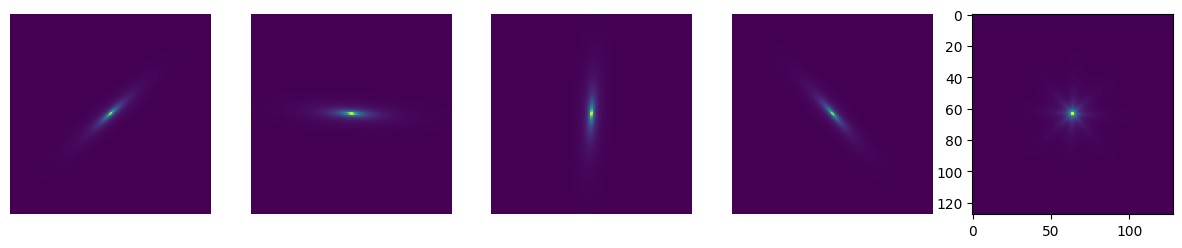

In [4]:
def cancel_shape_noise(gal_obj, nrot):

    rotated_gals = []
    for i in range(nrot):
        rot_ang = np.pi / nrot * i
        ang = rot_ang * galsim.radians
        gal_obj = gal_obj.rotate(ang)
        rotated_gals.append(gal_obj)
        
    return rotated_gals

rotated_gals = cancel_shape_noise(galaxy, 4)

nn = 128
scale = 0.01
plt.subplots(1, 5, figsize=(15, 3))
for i in range(4):
    plt.subplot(1, 5, i+1)
    plt.imshow(rotated_gals[i].drawImage(nx=nn, ny=nn, scale=scale).array)
    plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(np.sum([gal.drawImage(nx=nn, ny=nn, scale=scale).array for gal in rotated_gals], axis=0))

### Maybe this above very involved process isn't needed? - Lets see if we can just use the disk HLR?
- turns out I'm a muppet and all the disk+bulge galaxies have a total hlr measurment 

5625
N_b+d: 23425
N_sersic: 58074


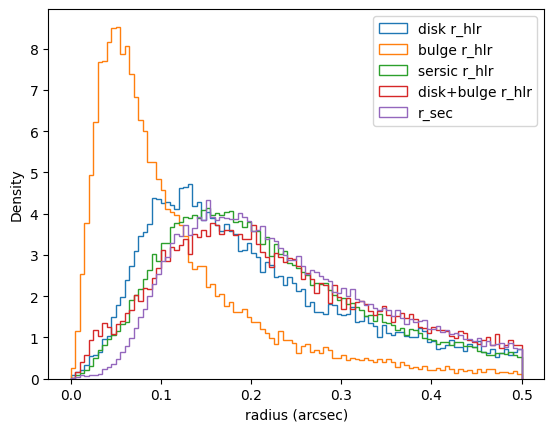

In [5]:
r_sec = np.load('cosmos_r_sec.npz')['arr_0']
failed = np.where(r_sec == -1)[0]
print(len(failed))

rec = cosmos.getParametricRecord(index=np.arange(cosmax))
sersic_mask = rec['use_bulgefit'].astype(bool)
inverted_mask = ~np.array(sersic_mask)

disk_hlr = rec['hlr'][sersic_mask][:, 0]
bulge_hlr = rec['hlr'][sersic_mask][:, 1]
total_hlr = rec['hlr'][sersic_mask][:, 2]
print('N_b+d:',len(total_hlr))

sersic_hlr = rec['hlr'][inverted_mask][:,0]
print('N_sersic:',len(sersic_hlr))

plt.hist(disk_hlr, bins=100, histtype='step', label='disk r_hlr', range=(0, 0.5), density=True);
plt.hist(bulge_hlr, bins=100, histtype='step', label='bulge r_hlr', range=(0, 0.5), density=True);
plt.hist(sersic_hlr, bins=100, histtype='step', label='sersic r_hlr', range=(0, 0.5), density=True);
plt.hist(total_hlr, bins=100, histtype='step', label='disk+bulge r_hlr', range=(0, 0.5), density=True);
plt.hist(r_sec, bins=100, histtype='step', label='r_sec', range=(0, 0.5), density=True);
plt.xlabel('radius (arcsec)')
plt.ylabel('Density')
plt.savefig('plots/radius_distributions.png')
plt.legend()

### Convolve all galaxies with an LSST-esq PSF to see what the distribution of observed sizes is like

In [6]:
# LSST Specifications
diameter = 8.4  # meters
effective_diameter = 6.423  # meters, area weighted
seeing = 0.67  # arcseconds

AtmosphericPSF = galsim.Kolmogorov(fwhm=seeing, flux=1.0, gsparams=bigfft)
OpticalPSF = galsim.OpticalPSF(lam=500, diam=effective_diameter, obscuration=effective_diameter/diameter)

TotPSF = galsim.Convolve([AtmosphericPSF, OpticalPSF])
#TotPSF = galsim.Moffat(beta=3.5, fwhm=0.6, trunc=0.6 * 4.0).shear(e1=0.02, e2=-0.02)

galaxies = cosmos.makeGalaxy(index=np.arange(cosmax), gal_type='parametric', noise_pad_size=0, rng=None, gsparams=bigfft)

In [7]:
mask_sersic = rec['use_bulgefit'].astype(bool)
mask_bd = ~np.array(mask_sersic)

bd_hlrs = rec['hlr'][:, 2] * mask_sersic
sersic_hlrs = rec['hlr'][:, 0] * mask_bd

all_hlrs = bd_hlrs + sersic_hlrs

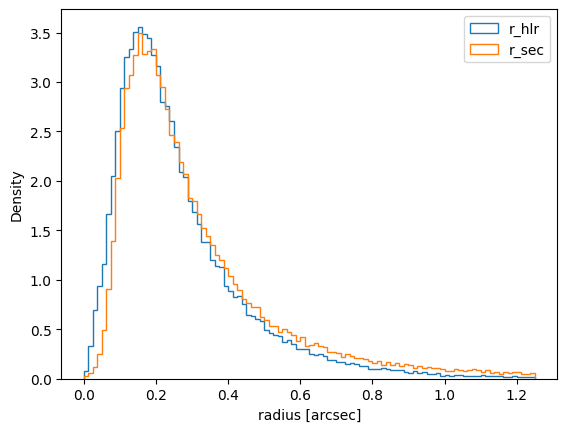

Fitted Parameters:
a: 3.8166483354047958
b: 1.1325019716424445
c: -1.2415285492031463


In [8]:
# Define the function to fit
def parameterization(x, a, b, c):
    return a * np.exp(-b * x) + c

# Define the histogram data
hist, bins = np.histogram(all_hlrs, bins=100, range=(0, 1.25), density=True)
x = (bins[:-1] + bins[1:]) / 2

# Fit the parameterization to the histogram data
popt, pcov = curve_fit(parameterization, x, hist)

# Generate the fitted curve
x_fit = np.linspace(0, 1.25, 100)
lsst_fit = parameterization(x_fit, a=9.2, b=3.2, c=-0.05)
cosmos_fit = parameterization(x_fit, a=popt[0], b=popt[1], c=popt[2])

# Plot the histogram and the fitted curve
plt.hist(all_hlrs, bins=100, histtype='step', range=(0, 1.25), density=True, label='r_hlr')
plt.hist(r_sec, bins=100, histtype='step', range=(0, 1.25), density=True, label='r_sec')
# plt.plot(x_fit, lsst_fit, 'r-', label='LSST SRD fit')
# plt.plot(x_fit, cosmos_fit, 'g--', label='COSMOS fit')
plt.xlabel('radius [arcsec]')
plt.ylabel('Density')
plt.legend()
plt.show()

# Print the fitted parameters
print('Fitted Parameters:')
print('a:', popt[0])
print('b:', popt[1])
print('c:', popt[2])

The LSST SRD defines r_sec = root(2) * sigma_p. The red line is a parametic fit to the distribution of r_sec for the WLD galaxies. If we pressume sigma_p = hlr and take the cosmos half light radii, multiply them all by 1.25 and then conver them as before to r_sec, we get a distribution that closely approximates that of the LSST SRD galaxies.

### NEED TO CHECK I CAN USE THESE EQUATIONS GENERICALLY!!!

In [9]:
# get effective size as per the definition of Chang et al. 2013

def calculate_effective_size(r_sec, r_PSF=0.67):
    # calculate effective size as per the definition of Chang et al. 2013
    # https://arxiv.org/pdf/1308.5170.pdf
    R_gals = r_sec**2 / r_PSF**2

    return R_gals

R_gals = calculate_effective_size(r_sec)

10988 9695 2726


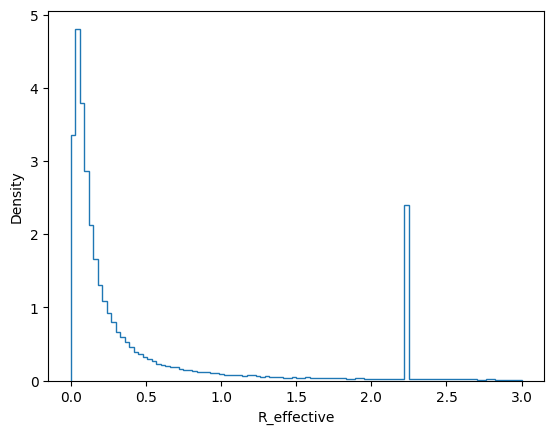

In [10]:
plt.hist(R_gals, bins=100, histtype='step', range=(0, 3), density=True);
plt.xlabel('R_effective')
plt.ylabel('Density')

R_1_5 = R_gals[R_gals > 1.5]
R_2  = R_gals[R_gals > 2.0]
R_3 = R_gals[R_gals > 3.0]
print(len(R_1_5), len(R_2), len(R_3))

Using the rescaling defined earlier, we get a distribution of effective size very similar to that of the LSST SRD, with an LSST-like PSF

### Ok, so lets try generate a few (1k) galaxies from cosmos
- determine their effective size
- rotate them to cancel noise
- apply shear
- convolve with PSF
- measure shear

In [95]:
rng = galsim.BaseDeviate(14)
nrot = 4
ngal = 10000

bigfft = galsim.GSParams(maximum_fft_size=60000)  # galsim setup

if ngal % nrot != 0:
    raise ValueError('ngal/nrot must be an integer')

gal_inds = np.where(all_hlrs > 0.)[0]
rand_inds = np.random.choice(len(gal_inds), size=ngal, replace=False)
gal_inds = gal_inds[rand_inds]
gal_sample = cosmos.makeGalaxy(gal_type='parametric', noise_pad_size=0, index=gal_inds)
print(len(gal_sample))

gal_sample_cancelled = [] 
for gal in gal_sample:
    rotated_gals = cancel_shape_noise(gal, nrot=4)
    shear_gals = [rotg.shear(g1=0.02) for rotg in rotated_gals]
    conv_gals = [galsim.Convolve([shearg, TotPSF]) for shearg in shear_gals]
    [gal_sample_cancelled.append(convg) for convg in conv_gals]

10000


Text(0.5, 1.0, 'Combined images')

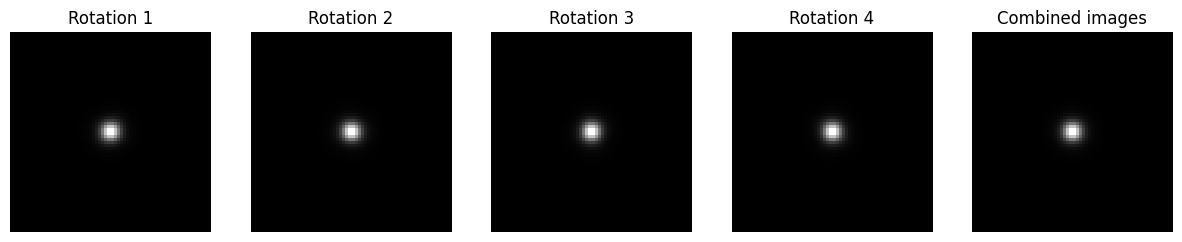

In [96]:
nn = 64
scale = 0.168
plt.subplots(1, 5, figsize=(15, 3))

gmin = 60
gmax = gmin+4

for i in range(4):
    plt.subplot(1, 5, i+1)
    plt.imshow(gal_sample_cancelled[gmin:gmax][i].drawImage(nx=nn, ny=nn, scale=scale).array, cmap='gray')
    plt.axis('off')
    plt.title('Rotation %d'%(i+1))

plt.subplot(1, 5, 5)
plt.imshow(np.sum([gal.drawImage(nx=nn, ny=nn, scale=scale).array for gal in gal_sample_cancelled[gmin:gmax]], axis=0), cmap='gray')
plt.axis('off')
plt.title('Combined images')

## Now we should have 1000 galaxies with cancelling shape noise
- So we try detect and measure the shear

#### Measure shear on individual galaxy

0.020000


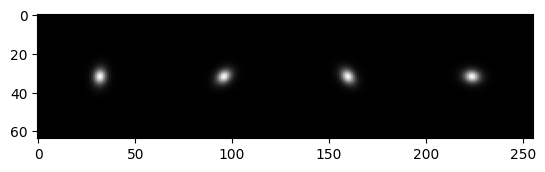

In [97]:
# gal = cosmos.makeGalaxy(index=2, gal_type='parametric', noise_pad_size=0, rng=None, gsparams=bigfft)
gal = gal_sample[0]
rotated_gals = cancel_shape_noise(gal, nrot=4)

true_shear = 0.02

sheared_gals = []
for gal in rotated_gals:
    gal_shear = gal.shear(g1=true_shear)
    gal_conv = galsim.Convolve([gal_shear, TotPSF])
    sheared_gals.append(gal_conv)

psf_arr = TotPSF.shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale).array

gal_arr = sheared_gals[0].shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale).array
for i in range(1, 4):
    next_arr = sheared_gals[i].shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale).array
    gal_arr = np.concatenate([gal_arr, next_arr], axis=1)

plt.imshow(gal_arr, cmap='gray')

fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=0.7, pix_scale=scale)

rcut = nn/2
indX = np.arange(int(nn/2), nn*4, nn)
indY = np.arange(int(nn/2), nn, nn)
inds = np.meshgrid(indY, indX, indexing="ij")
coords = np.vstack([np.ravel(_) for _ in inds]).T

# measure shear with FPFS
mms = fpTask.measure(gal_arr, coords)
mms = fpTask.get_results(mms)
ells = fpfs.catalog.fpfs_m2e(mms, const=2000)
resp = np.average(ells['fpfs_R1E'])
shear = np.average(ells['fpfs_e1'])/resp

print('%1.6f'%shear)

#### Measure shear on full sample

In [98]:
psf_arr = TotPSF.shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale).array

# initialize FPFS shear measurement task
fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=0.7, pix_scale=scale)

all_mms = []
for i in trange(4):
    gal = gal_sample_cancelled[i]
    gal_arr = gal.shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale).array
    
    # Force detection at the stamp center point (ngrid//2, ngrid//2)
    rcut = nn/2
    indX = np.arange(int(nn/2), nn, nn)
    indY = np.arange(int(nn/2), nn, nn)
    inds = np.meshgrid(indY, indX, indexing="ij")
    coords = np.vstack([np.ravel(_) for _ in inds]).T

    # measure shear with FPFS on individual galaxies
    mms = fpTask.measure(gal_arr, coords)
    mms = fpTask.get_results(mms)
    all_mms.append(mms)

# combine all FPFS moments into single recarray
combined_mms = np.recarray((len(all_mms)), dtype=all_mms[0].dtype)
for i in range(len(all_mms)):
    combined_mms[i] = all_mms[i]

# convert momemnts to ellipticity estimates
ells = fpfs.catalog.fpfs_m2e(combined_mms, const=2000)
resp = np.average(ells['fpfs_R1E'])
shear = np.average(ells['fpfs_e1'])/resp

print('%1.6f'%shear)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

0.020000


#### Include detection of galaxies

In [99]:
rcut = 16

psf_arr = TotPSF.shift(0.5*scale, 0.5*scale).drawImage(nx=rcut*2, ny=rcut*2, scale=scale).array

p1 = nn //2 - rcut
p2 = nn //2 - rcut
psf_arr2 = np.pad(psf_arr, ((p1, p1), (p2, p2)))

# initialize FPFS shear measurement task
fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=0.52, pix_scale=scale)

all_mms = []
for i in trange(16):
    gal = gal_sample_cancelled[i]
    gal_arr = gal.shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale).array

    coords = fpTask.detect_sources(gal_arr,psf_arr2,thres=0.01,thres2=-0.00,)

    # measure shear with FPFS on individual galaxies
    mms = fpTask.measure(gal_arr, coords)
    mms = fpTask.get_results(mms)
    all_mms.append(mms)

# combine all FPFS moments into single recarray
combined_mms = np.recarray((len(all_mms)), dtype=all_mms[0].dtype)
for i in range(len(all_mms)):
    combined_mms[i] = all_mms[i]

# convert momemnts to ellipticity estimates
ells = fpfs.catalog.fpfs_m2e(combined_mms, const=2000)
resp = np.average(ells['fpfs_R1E'])
shear = np.average(ells['fpfs_e1'])/resp

print('%1.6f'%shear)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  7.45it/s]

0.020000


#### Now lets look at the effect of using different shapelet kernel sizes in a constant shear case with FPFS handling detection

In [100]:
def detect_and_measure(sigma_arcsec, psf_arr, gal_list, nn=64, scale=0.168, dn=0.5):

    # initialize FPFS shear measurement task
    fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=sigma_arcsec, pix_scale=scale)

    p1 = nn //2 - rcut
    p2 = nn //2 - rcut
    psf_arr_pad = np.pad(psf_arr, ((p1, p1), (p2, p2)))

    all_mms = []
    for i in trange(len(gal_list)):
        gal = gal_list[i]
        gal_arr = gal.shift(dn*scale, dn*scale).drawImage(nx=nn, ny=nn, scale=scale).array

        coords = fpTask.detect_sources(gal_arr,psf_arr_pad,thres=0.01,thres2=-0.00,)

        # measure shear with FPFS on individual galaxies
        mms = fpTask.measure(gal_arr, coords)
        mms = fpTask.get_results(mms)
        all_mms.append(mms)

    # combine all FPFS moments into single recarray
    combined_mms = np.recarray((len(all_mms)), dtype=all_mms[0].dtype)
    for i in range(len(all_mms)):
        combined_mms[i] = all_mms[i]

    # convert momemnts to ellipticity estimates
    ells = fpfs.catalog.fpfs_m2e(combined_mms, const=2000)
    resp = np.average(ells['fpfs_R1E'])
    shear = np.average(ells['fpfs_e1'])/resp

    return shear

In [101]:
rcut = 16

psf_arr = TotPSF.shift(0.5*scale, 0.5*scale).drawImage(nx=rcut*2, ny=rcut*2, scale=scale).array

# inner radius shear mesaurement
inner_shear = detect_and_measure(0.52, psf_arr, gal_sample_cancelled[:4])
print('%1.6e'%inner_shear)
print('error = %1.6e'%(inner_shear - true_shear))

# outer radius shear mesaurement
outer_shear = detect_and_measure(0.7, psf_arr, gal_sample_cancelled[:4])
print('%1.6e'%outer_shear)
print('error = %1.6e'%(outer_shear - true_shear))

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00,  7.30it/s]


2.000089e-02
error = 8.898758e-07


100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

1.999731e-02
error = -2.689031e-06


## Final test: Add IA shear and see how we perform
- 

In [102]:
from scipy.signal import convolve2d

def align_and_convolve(gal, gal_ind, psf, A=0.00136207, phi=0, beta=0.82404653, method='scipy', nn=64, scale=0.168):
    '''
    Uses FPFS centering convention, so galaxies do not need to be shifted
    prior to measurement with FPFS!
    '''
    # get details of galaxy half light radius
    rec = cosmos.getParametricRecord(index=gal_ind)
    if rec['use_bulgefit'].astype(bool):
        hlr = rec['hlr'][2]
    else:
        hlr = rec['hlr'][0]
    
    # initialise IA transform object
    IaTransform = batsim.transforms.IaTransform(scale=scale,
                                                hlr=hlr,
                                                A=A, 
                                                phi=phi,
                                                beta=beta,
                                                center=None
                                                )

    # Create and transform stamp object to draw image to
    stamp = batsim.stamp.Stamp(nn=nn, scale=scale, centering='fpfs')
    stamp.transform_grids(IaTransform)
    
    # sample galaxy to stamp
    gal_ia = stamp.sample_galaxy(gal)

    if method=='scipy':
        # convolve with PSF
        psf_arr = psf.shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale, method='auto').array
        psf_arr /= np.sum(psf_arr)

        # Convolution of the galaxy with the PSF
        conv_arr = convolve2d(gal_ia, psf_arr, mode='same')
        conv_im = galsim.Image(conv_arr, scale=scale).bin(upscale, upscale).array
        return conv_im
    elif method=='galsim':
        conv_obj = batsim.stamp.interp_and_convolve(gal_ia, psf, scale=scale)
        return conv_obj
    else:
        raise ValueError('method must be "scipy" or "galsim"')

0.010001000200050014
2 0.02540334662467903 190


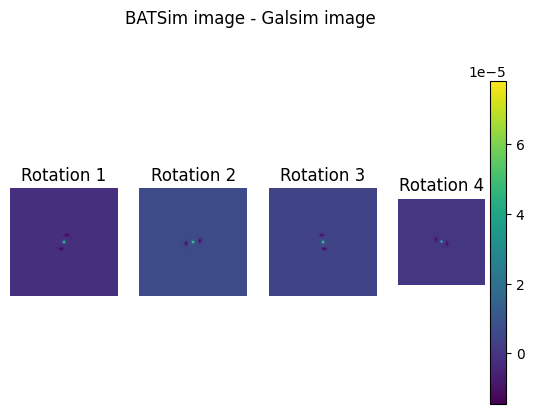

In [113]:
nrot = 4
nn = 256
scale = 0.168

Aia_e = 0.02
Aia_g = galsim.Shear(e1=Aia_e).g1
print(Aia_g)

gsparams = galsim.GSParams(maximum_fft_size=60000, folding_threshold=0.05)

i = 1
gal = gal_sample[i]
gal.withGSParams(gsparams)
gal_ind = gal_inds[i]

simscale = gal.nyquist_scale
simnn = gal.getGoodImageSize(simscale)
while simnn > 512:
    i = i + 1
    gal = gal_sample[i]
    gal.withGSParams(gsparams)
    gal_ind = gal_inds[i]
    simscale = gal.nyquist_scale
    simnn = gal.getGoodImageSize(simscale)
print(i, simscale, simnn)

rotated_gals = cancel_shape_noise(gal, nrot=nrot)
ia_gals = [align_and_convolve(gal=rotg, 
                                gal_ind=gal_ind, 
                                psf=TotPSF, 
                                A=0.02, 
                                beta=0.,
                                method='galsim',
                                nn=simnn,
                                scale=simscale,
                                ) for rotg in rotated_gals]

ia_gals = [iag.drawImage(nx=nn, ny=nn, scale=scale, method='auto').array for iag in ia_gals]

shear_gals = [rotg.shear(g1=Aia_g) for rotg in rotated_gals]
conv_gals = [galsim.Convolve([shearg, TotPSF]) for shearg in shear_gals]
for i in range(4):
    plt.subplot(1, 4, i+1)
    resi = ia_gals[i] - conv_gals[i].shift(0.5*simscale, 0.5*simscale).drawImage(nx=nn, ny=nn, scale=scale, method='auto').array
    plt.imshow(resi)
    plt.axis('off')
    plt.title('Rotation %d'%(i+1))
plt.colorbar()
plt.suptitle('BATSim image - Galsim image')
plt.savefig('plots/post-convolution_residuals.png')

In [116]:
rcut = 64

psf_arr = TotPSF.shift(0.5*scale, 0.5*scale).drawImage(nx=rcut*2, ny=rcut*2, scale=scale).array

# initialize FPFS shear measurement task
fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=0.3, pix_scale=scale)

p1 = nn //2 - rcut
p2 = nn //2 - rcut
psf_arr_pad = np.pad(psf_arr, ((p1, p1), (p2, p2)))

# calculate shear for galsim convolution
all_mms = []
for i in trange(4):
    gal_arr = conv_gals[i].shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale).array
    coords = fpTask.detect_sources(gal_arr,psf_arr_pad,thres=0.01,thres2=-0.00)

    # measure shear with FPFS on individual galaxies
    mms = fpTask.measure(gal_arr, coords)
    mms = fpTask.get_results(mms)
    all_mms.append(mms)

# combine all FPFS moments into single recarray
combined_mms = np.recarray((len(all_mms)), dtype=all_mms[0].dtype)
for i in range(len(all_mms)):
    combined_mms[i] = all_mms[i]

# convert momemnts to ellipticity estimates
ells = fpfs.catalog.fpfs_m2e(combined_mms, const=2000)
resp = np.average(ells['fpfs_R1E'])
shear = np.average(ells['fpfs_e1'])/resp
print('%1.6e'%shear)
print('perc error = %1.6f'%((shear - Aia_g)/Aia_g *100))

rcut = 16

psf_arr = TotPSF.shift(0.5*simscale, 0.5*simscale).drawImage(nx=rcut*2, ny=rcut*2, scale=scale).array

# initialize FPFS shear measurement task
fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=0.3, pix_scale=scale)

p1 = nn //2 - rcut
p2 = nn //2 - rcut
psf_arr_pad = np.pad(psf_arr, ((p1, p1), (p2, p2)))

# calculate shear array level BATSim convolution
all_mms = []
for i in trange(4):
    gal_arr = ia_gals[i]
    coords = fpTask.detect_sources(gal_arr,psf_arr_pad,thres=0.01,thres2=-0.00)

    # measure shear with FPFS on individual galaxies
    mms = fpTask.measure(gal_arr, coords)
    mms = fpTask.get_results(mms)
    all_mms.append(mms)
combined_mms = rfn.stack_arrays(all_mms, usemask=False, asrecarray=True)

# convert momemnts to ellipticity estimates
ells = fpfs.catalog.fpfs_m2e(combined_mms, const=2000)
resp = np.average(ells['fpfs_R1E'])
shear = np.average(ells['fpfs_e1'])/resp

print('%1.6e'%shear)
print('perc error = %1.6f'%((shear - Aia_g)/Aia_g * 100))

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


1.000109e-02
perc error = 0.000930


100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

1.000057e-02
perc error = -0.004266


In [93]:
rng = galsim.BaseDeviate(14)
nn = 256
scale = 0.168
nrot = 4

Aia_e = 0.02
Aia_g = galsim.Shear(e1=Aia_e).g1
print(Aia_g)

bigfft = galsim.GSParams(maximum_fft_size=40000, folding_threshold=0.5)  # galsim setup

if ngal % nrot != 0:
    raise ValueError('ngal/nrot must be an integer')

galsim_sample = [] 
for gal in tqdm(gal_sample):
    gal.withGSParams(bigfft)
    rotated_gals = cancel_shape_noise(gal, nrot=4)
    shear_gals = [rotg.shear(g1=Aia_g) for rotg in rotated_gals]
    conv_gals = [galsim.Convolve([shearg, TotPSF]) for shearg in shear_gals]
    arr_gals = [convg.shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale).array for convg in conv_gals]
    [galsim_sample.append(arrg) for arrg in arr_gals]

# batsim_scipy_sample = []
# for i in trange(len(gal_sample)):
#     rotated_gals = cancel_shape_noise(gal_sample[i], nrot=4)
#     gal_ind = gal_inds[i]
#     conv_gals = []
#     for rotg in rotated_gals:
#         conv_gals.append(align_and_convolve(gal=rotg, 
#                                             gal_ind=gal_ind, 
#                                             psf=TotPSF, 
#                                             A=Aia_e, 
#                                             beta=0.,
#                                             method='scipy',
#                                             nn=nn,
#                                             scale=scale
#                                             ))
#     [batsim_scipy_sample.append(convg) for convg in conv_gals]

batsim_galsim_sample = []
simscales = []
for i in trange(len(gal_sample)):
    gal_sample[i].withGSParams(bigfft)
    simscale = gal_sample[i].nyquist_scale
    simnn = gal_sample[i].getGoodImageSize(simscale)
    if simnn > 512:
        continue

    rotated_gals = cancel_shape_noise(gal_sample[i], nrot=4)
    gal_ind = gal_inds[i]
    conv_gals = []
    for rotg in rotated_gals:
        conv_gals.append(align_and_convolve(gal=rotg, 
                                            gal_ind=gal_ind, 
                                            psf=TotPSF, 
                                            A=Aia_e, 
                                            beta=0.,
                                            method='galsim',
                                            nn=simnn,
                                            scale=simscale
                                            ))
        simscales.append(simscale)
    arr_gals = [convg.drawImage(nx=nn, ny=nn, scale=scale).array for convg in conv_gals]
    [batsim_galsim_sample.append(arrg) for arrg in arr_gals]

0.010001000200050014


  0%|          | 0/24981 [00:00<?, ?it/s]

  4%|▎         | 924/24981 [00:19<08:20, 48.05it/s]


KeyboardInterrupt: 

In [76]:
def test_kernel_size(sigma_arcsec, psf_arr, gal_arr_list, scale):

    # initialize FPFS shear measurement task
    fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=sigma_arcsec, pix_scale=scale)

    p1 = nn //2 - rcut
    p2 = nn //2 - rcut
    psf_arr_pad = np.pad(psf_arr, ((p1, p1), (p2, p2)))

    all_mms = []
    for gal_arr in tqdm(gal_arr_list):
        coords = fpTask.detect_sources(gal_arr,psf_arr_pad,thres=0.01,thres2=-0.00,)

        # measure shear with FPFS on individual galaxies
        mms = fpTask.measure(gal_arr, coords)
        mms = fpTask.get_results(mms)
        all_mms.append(mms)
    combined_mms = rfn.stack_arrays(all_mms, usemask=False, asrecarray=True)

    # convert momemnts to ellipticity estimates
    ells = fpfs.catalog.fpfs_m2e(combined_mms, const=2000)
    resp = np.average(ells['fpfs_R1E'])
    shear = np.average(ells['fpfs_e1'])/resp
    shear_err = np.std(ells["fpfs_e1"]) / np.abs(resp) / np.sqrt(ngal)

    return shear, shear_err

rcut = 64

psf_arr = TotPSF.shift(0.5*scale, 0.5*scale).drawImage(nx=rcut*2, ny=rcut*2, scale=scale).array

shear, shear_err = test_kernel_size(0.3, psf_arr, galsim_sample, scale=scale)
print('%1.6e'%shear)
print('error = %1.6f'%shear_err)
print('bias = %1.6f'%((shear - Aia_g)/Aia_g * 100))
thresh = max(2.0 * shear_err, 1e-5)
assert np.all(np.abs(shear - Aia_g) < thresh)

In [90]:
rcut = 64

all_mms = []
for i in trange(len(batsim_galsim_sample)):
    simscale = simscales[i]
    psf_arr = TotPSF.shift(0.5*simscale, 0.5*simscale).drawImage(nx=rcut*2, ny=rcut*2, scale=scale).array
     # initialize FPFS shear measurement task
    fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=0.8, pix_scale=scale)
    p1 = nn //2 - rcut
    p2 = nn //2 - rcut
    psf_arr_pad = np.pad(psf_arr, ((p1, p1), (p2, p2)))
    
    gal_arr = batsim_galsim_sample[i]
    coords = fpTask.detect_sources(gal_arr,psf_arr_pad,thres=0.01,thres2=-0.00,)
    # measure shear with FPFS on individual galaxies
    mms = fpTask.measure(gal_arr, coords)
    mms = fpTask.get_results(mms)
    all_mms.append(mms)

combined_mms = rfn.stack_arrays(all_mms, usemask=False, asrecarray=True)

# convert momemnts to ellipticity estimates
ells = fpfs.catalog.fpfs_m2e(combined_mms, const=2000)
resp = np.average(ells['fpfs_R1E'])
shear = np.average(ells['fpfs_e1'])/resp
shear_err = np.std(ells["fpfs_e1"]) / np.abs(resp) / np.sqrt(ngal)

print('%1.6e'%shear)
print('error = %1.6f'%shear_err)
print('perc bias = %1.6f'%((shear - Aia_g)/Aia_g * 100))
thresh = max(2.0 * shear_err, 1e-5)
assert np.all(np.abs(shear - Aia_g) < thresh)

100%|██████████| 204/204 [00:47<00:00,  4.28it/s]

9.998165e-03
error = 0.051664
perc bias = -0.028354


In [ ]:
rcut = 16

psf_arr = TotPSF.shift(0.5*scale, 0.5*scale).drawImage(nx=rcut*2, ny=rcut*2, scale=scale).array

kernels = np.linspace(0.3,1.2,20)

galsim_bias = np.empty(len(kernels))
batsim_galsim_bias = np.empty(len(kernels))
batsim_scipy_bias = np.empty(len(kernels))
for i in trange(len(kernels)):
    print(kernels[i])
    galsim_shear, _ = test_kernel_size(kernels[i], psf_arr, galsim_sample)
    galsim_bias[i] = (galsim_shear - Aia_g)/Aia_g *100

    batsim_galsim_shear, _ = test_kernel_size(kernels[i], psf_arr, batsim_galsim_sample)
    batsim_galsim_bias[i] = (batsim_galsim_shear - Aia_g)/Aia_g *100

    # batsim_scipy_shear, _ = test_kernel_size(kernels[i], psf_arr, batsim_scipy_sample)
    # batsim_scipy_bias[i] = (batsim_scipy_shear - Aia_g)/Aia_g *100


  0%|          | 0/20 [00:00<?, ?it/s]

0.3


  0%|          | 0/20 [00:00<?, ?it/s]


AssertionError: image and PSF should have the same                shape. Please do padding before using this function.

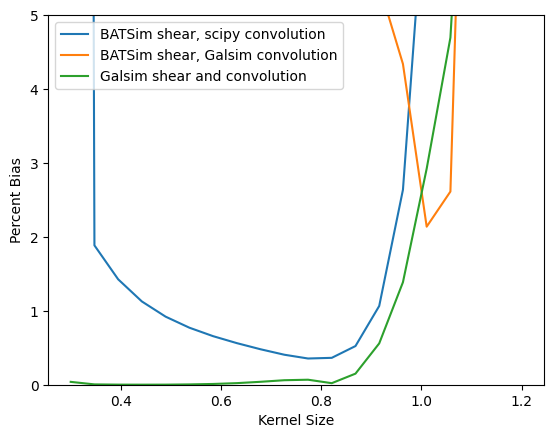

In [ ]:
plt.plot(kernels, abs(batsim_scipy_bias), label='BATSim shear, scipy convolution')
plt.plot(kernels, abs(batsim_galsim_bias), label='BATSim shear, Galsim convolution')
plt.plot(kernels, abs(galsim_bias), label='Galsim shear and convolution')
plt.legend()
plt.xlabel('Kernel Size')
plt.ylabel('Percent Bias')
plt.ylim([0,5])
plt.savefig('kernel_size_bias.png', dpi=300)